In [1]:
from openai.types.audio import TranscriptionVerbose, TranscriptionWord
from typing import List, Dict, Optional, Tuple, Union
from dataclasses import dataclass
import pandas as pd
from Levenshtein import distance
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from align import AlignedWord, deserialize_transcription_from_file, convert_file_times_to_absolute_times, word_similarity
import copy

In [2]:
def pair_libretto_lines_simple(german_text, english_text, character_names):
    lines_de = german_text.split("\n\n")
    lines_en = english_text.split("\n\n")

    # Remove empty lines
    lines_de = [line for line in lines_de if line.strip()]
    lines_en = [line for line in lines_en if line.strip()]

    print(len(lines_de), len(lines_en))

    # print the average length of each german line
    print(sum(len(line) for line in lines_de) / len(lines_de))
    print(sum(len(line) for line in lines_en) / len(lines_en))

    print(len(lines_de), len(lines_en))

    length_ratios = [len(de) / len(en) for de, en in zip(lines_de, lines_en)]

    # print a chart of length_ratios

    # Plot the length ratios
    plt.figure(figsize=(10, 5))
    plt.plot(length_ratios)
    plt.title('Length Ratios of German and English Lines')
    plt.xlabel('Line Number')
    plt.ylabel('Length Ratio')
    plt.grid(True)
    plt.show()

    # Find the index where the length ratios start to deviate significantly
    threshold = 1.5  # Adjust this threshold as needed
    deviation_index = next((i for i, ratio in enumerate(length_ratios) if abs(ratio - 1) > threshold), None)

    if deviation_index is not None:
        print(f"Significant deviation starts at line {deviation_index}")
        print(f"German line: {lines_de[deviation_index]}")
        print(f"English line: {lines_en[deviation_index]}")
    else:
        print("No significant deviation found.")

    return list(zip(lines_de, lines_en))

404 404
154.4628712871287
153.759900990099
404 404


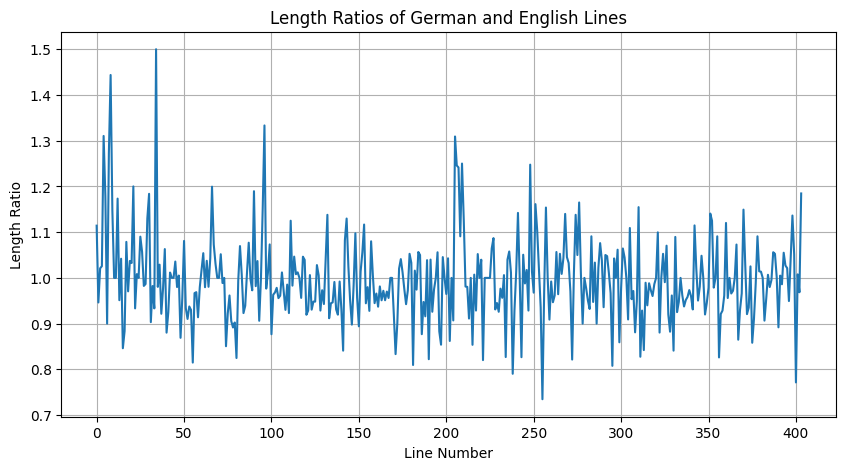

No significant deviation found.


In [3]:
with open("libretti/rheingold_de.txt", "r", encoding="utf-8") as f:
    libretto_de = f.read()

with open("libretti/rheingold_en.txt", "r", encoding="utf-8") as f:
    libretto_en = f.read()

characters = [
    "Rheintöchter",
    "Wotan",
    "Woglinde",
    "Wellgunde",
    "Flosshilde",
    "Alberich",
    "Fricka",
    "Freia",
    "Fasolt",
    "Fafner",
    "Froh",
    "Donner",
    "Loge",
    "Mime",
    "Erda"
]

pairs = pair_libretto_lines_simple(libretto_de, libretto_en, characters)

In [4]:
for de, en in pairs:
    print("DE:", de)
    print("EN:", en)
    print("---")

DE: (Auf dem Grunde des Rheines. Grünliche Dämmer-
ung, nach oben zu lichter, nach unten zu dunkler. Die
Höhe ist von wogendem Gewässer erfüllt, das rastlos
von rechts nach links zu strömt. Nach der Tiefe zu
lösen die Fluthen sich in einen immer feineren
feuchten Nebel auf, so daß der Raum in Manneshöhe
vom Boden auf gänzlich frei vom Wasser zu sein
scheint, welches wie in Wolkenzügen über den nächt-
lichen Grund dahin fließt. Überall ragen schroffe
Felsenriffe aus der Tiefe auf, und grenzen den Raum
der Bühne ab; der ganze Boden ist in ein wildes
Zackengewirr zerspalten, so daß er nirgends voll-
kommen eben ist, und nach allen Seiten hin in
dichtester Finsterniss tiefere Schlüfte annehmen läßt.)
(Hier wird der Vorhang aufgezogen. Volles Wogen
der Wassertiefe. Woglinde kreist in anmuthig
schwimmender Bewegung um das mittlere Riff.)
EN: At the bottom of the Rhine
(Greenish twilight, lighter above, darker below.
The upper part of the scene is filled with moving
water, which restlessly st

In [4]:
def align_transcription_with_libretto(
    transcription: List[TranscriptionWord],
    libretto: List[str],
    min_similarity: float = 0.5
) -> List[AlignedWord]:
    """
    Align transcription with libretto using dynamic programming.
    Returns list of aligned words with timing information where available.
    
    Args:
        transcription: List of TranscriptionWord objects
        libretto: List of ground truth words
        min_similarity: Minimum similarity score to consider words as matching
    """
    
    # Initialize scoring matrix
    m, n = len(transcription), len(libretto)
    score_matrix = [[0.0] * (n + 1) for _ in range(m + 1)]
    backtrack = [[None] * (n + 1) for _ in range(m + 1)]
    
    # Gap penalties
    gap_penalty = -0.5
    
    # Fill scoring matrix
    for i in range(m + 1):
        score_matrix[i][0] = i * gap_penalty
    for j in range(n + 1):
        score_matrix[0][j] = j * gap_penalty
        
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            match_score = score_matrix[i-1][j-1] + similarity
            
            delete_score = score_matrix[i-1][j] + gap_penalty
            insert_score = score_matrix[i][j-1] + gap_penalty
            
            best_score = max(match_score, delete_score, insert_score)
            score_matrix[i][j] = best_score
            
            # Track the move that led to this cell
            if best_score == match_score:
                backtrack[i][j] = 'match'
            elif best_score == delete_score:
                backtrack[i][j] = 'delete'
            else:
                backtrack[i][j] = 'insert'
    
    # Backtrack to build alignment
    aligned_words: List[AlignedWord] = []
    i, j = m, n
    
    while i > 0 or j > 0:
        if i > 0 and j > 0 and backtrack[i][j] == 'match':
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            if similarity >= min_similarity:
                # Good match - use transcription timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=transcription[i-1].start,
                    end=transcription[i-1].end
                ))
            else:
                # Poor match - include word without timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=None,
                    end=None
                ))
            i -= 1
            j -= 1
        elif i > 0 and (j == 0 or backtrack[i][j] == 'delete'):
            # Skip transcription word
            i -= 1
        else:
            # Insert libretto word without timing
            aligned_words.append(AlignedWord(
                word=libretto[j-1],
                start=None,
                end=None
            ))
            j -= 1
    
    return list(reversed(aligned_words))

In [5]:
# Load transcriptions
transcriptions: List[TranscriptionVerbose] = []
for i in range(1, 29):
    i_string = str(i).zfill(3)
    transcription = deserialize_transcription_from_file(f'transcribed/{i_string}.json')
    transcriptions.append(transcription)

transcriptions = convert_file_times_to_absolute_times(transcriptions)

all_words: List[TranscriptionWord] = [word for transcription in transcriptions for word in transcription.words]

# Load libretto
with open('libretti/rheingold_de.txt', 'r') as f:
    libretto = f.read()

# preprocess libretto

# remove anything between parentheses
# libretto = re.sub(r'\([^)]*\)', '', libretto)

# remove character names
# for character in characters:
#     libretto = libretto.replace("\n" + character, "")

libretto = libretto.split()

# Align texts
aligned_words_uninterpolated = align_transcription_with_libretto(all_words, libretto, min_similarity=0.3)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words_uninterpolated if word.start is not None and word.end is not None]) / len(aligned_words_uninterpolated)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.6014183019234506


In [6]:
def interpolate_word_timings(
    aligned_words: List[AlignedWord],
    max_interpolation_window: float = 8.0
) -> List[AlignedWord]:
    """
    Interpolate timing for words between known timestamps within a maximum window.
    
    Args:
        aligned_words: List of AlignedWord objects
        max_interpolation_window: Maximum time window in seconds for interpolation
        
    Returns:
        New list of AlignedWord objects with interpolated timings
    """
    result = copy.deepcopy(aligned_words)
    
    # First pass: identify sequences of words to interpolate
    sequences = []
    current_sequence = []
    last_known_end = None
    
    for i, word in enumerate(result):
        if word.start is not None and word.end is not None:
            # Found a word with known timing
            if current_sequence and last_known_end is not None:
                # Check if this word is within the interpolation window
                if word.start - last_known_end <= max_interpolation_window:
                    # Add the current word as the end anchor of the sequence
                    current_sequence.append(i)
                    sequences.append(current_sequence)
                current_sequence = []
            last_known_end = word.end
            current_sequence = [i]  # Start new sequence with this word
        elif current_sequence:
            # Add word without timing to current sequence
            current_sequence.append(i)
    
    # Second pass: perform interpolation for each valid sequence
    for sequence in sequences:
        if len(sequence) < 2:
            continue
        
        start_idx = sequence[0]
        end_idx = sequence[-1]
        start_word = result[start_idx]
        end_word = result[end_idx]
        
        # Skip if either anchor point doesn't have timing
        if (start_word.start is None or start_word.end is None or 
            end_word.start is None or end_word.end is None):
            continue
        
        # Calculate time distribution
        total_words = len(sequence)
        if total_words <= 1:
            continue
            
        # For the first word in sequence, keep its original end time
        # For the last word in sequence, keep its original start time
        total_time = end_word.start - start_word.end
        words_to_interpolate = total_words - 1  # excluding first word
        
        if words_to_interpolate <= 0:
            continue
            
        # Calculate time per word
        time_per_word = total_time / words_to_interpolate
        
        # Set timings for words in between
        current_time = start_word.end
        for i in range(1, len(sequence)):
            idx = sequence[i]
            word = result[idx]
            
            if i == len(sequence) - 1:
                # Last word in sequence - keep its original timing
                word.start = end_word.start
                word.end = end_word.end
            else:
                # Interpolated word
                word.start = current_time
                word.end = current_time + time_per_word
                current_time += time_per_word
    
    return result

In [7]:
aligned_words = interpolate_word_timings(aligned_words_uninterpolated, max_interpolation_window=20)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words if word.start is not None and word.end is not None]) / len(aligned_words)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.9452108024091704


In [5]:
# write aligned words to csv

def write_aligned_words_to_csv(aligned_words: List[AlignedWord], filename: str):
    # Convert list of AlignedWord to list of dictionaries
    data = [{'word': w.word, 'start': w.start, 'end': w.end} for w in aligned_words]
    
    # Create DataFrame and write to CSV
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def read_edited_aligned_words_from_csv(filename: str) -> List[AlignedWord]:
    # Read CSV into DataFrame
    df = pd.read_csv(filename)

    # Convert DataFrame to list of AlignedWord
    aligned_words = [AlignedWord(row['word'], row['start'], row['end']) for _, row in df.iterrows()]

    # replace nans with None
    for word in aligned_words:
        if pd.isna(word.start):
            word.start = None
        if pd.isna(word.end):
            word.end = None

    return aligned_words

# write_aligned_words_to_csv(aligned_words, 'aligned_words.csv')

# read aligned words from csv
aligned_words = read_edited_aligned_words_from_csv('aligned_words.csv')

In [10]:
from moviepy.editor import (
    AudioFileClip, TextClip, CompositeVideoClip, 
    ColorClip, concatenate_audioclips, VideoClip
)
from typing import List

def create_karaoke_video(
    aligned_words: List[AlignedWord],
    output_filename: str = "karaoke.mp4",
    context_lines: int = 3,
    words_per_line: int = 7,
    font_size: int = 40,
    video_width: int = 1280,
    video_height: int = 720,
    fps: int = 24,
    text_timeout: float = 5.0  # Time in seconds before text disappears
):
    # First, combine all audio files
    audio_files = [f"ring/{str(i).zfill(3)}.wav" for i in range(1, 6)]
    audio_clips = [AudioFileClip(f) for f in audio_files]
    combined_audio = concatenate_audioclips(audio_clips)
    total_duration = sum(clip.duration for clip in audio_clips)
    
    # Create background
    background = ColorClip(size=(video_width, video_height), color=(0, 0, 0))
    background = background.set_duration(total_duration)
    
    # Group words into lines
    lines = []
    current_line = []
    for word in aligned_words:
        current_line.append(word)
        if len(current_line) >= words_per_line:
            lines.append(current_line)
            current_line = []
    if current_line:
        lines.append(current_line)
    
    # Find the first timestamp where words appear
    first_timestamp = float('inf')
    for word in aligned_words:
        if word.start is not None and word.start < first_timestamp:
            first_timestamp = word.start
    
    def find_last_active_time_before(time: float) -> float:
        """Find the last word end time before the given timestamp."""
        last_time = -float('inf')
        for word in aligned_words:
            if word.end is not None and word.end <= time and word.end > last_time:
                last_time = word.end
        return last_time
    
    def get_context_lines(time: float) -> tuple[List[List[AlignedWord]], bool]:
        """
        Get the current line and surrounding context lines based on time.
        Returns (context_lines, has_current_word)
        """
        current_line_idx = None
        has_current_word = False
        
        # If we're before the first word, return nothing
        if time < first_timestamp:
            return [], False
        
        # Find the current line based on time
        for i, line in enumerate(lines):
            for word in line:
                if word.start is not None and word.end is not None:
                    if word.start <= time <= word.end:
                        current_line_idx = i
                        has_current_word = True
                        break
            if current_line_idx is not None:
                break
        
        # If no current word is found, use the line containing the last word before this time
        if current_line_idx is None:
            last_active = find_last_active_time_before(time)
            if last_active == -float('inf') or time - last_active > text_timeout:
                return [], False
                
            for i, line in enumerate(lines):
                for word in line:
                    if word.end is not None and word.end == last_active:
                        current_line_idx = i
                        break
                if current_line_idx is not None:
                    break
        
        if current_line_idx is None:
            return [], False
        
        # Get context lines
        start_idx = max(0, current_line_idx - context_lines)
        end_idx = min(len(lines), current_line_idx + context_lines + 1)
        return lines[start_idx:end_idx], has_current_word
    
    def make_frame(t: float):
        """Create a frame for the given timestamp."""
        context, has_current_word = get_context_lines(t)
        if not context:
            return background.get_frame(t)
        
        text_clips = []
        y_position = video_height // 2 - (len(context) * font_size) // 2
        
        for line in context:
            # First, create all word clips to calculate total width
            word_clips = []
            total_width = 0
            space_width = TextClip(" ", fontsize=font_size, color='white', font='Big Caslon').w
            
            for word in line:
                # Only highlight words if we have a current word
                is_current = (has_current_word and 
                            word.start is not None and 
                            word.end is not None and 
                            word.start <= t <= word.end)
                
                clip = TextClip(
                    word.word,
                    fontsize=font_size,
                    color='yellow' if is_current else 'white',
                    font='Big Caslon'
                )
                word_clips.append(clip)
                total_width += clip.w + space_width
            
            # Position words horizontally centered
            x_position = (video_width - total_width) // 2
            
            # Add each word clip with proper positioning
            for word_clip in word_clips:
                positioned_clip = word_clip.set_position((x_position, y_position))
                text_clips.append(positioned_clip)
                x_position += word_clip.w + space_width
            
            y_position += int(font_size * 1.5)
        
        return CompositeVideoClip([background] + text_clips).get_frame(t)
    
    # Create video clip with explicit fps
    video = VideoClip(make_frame, duration=total_duration).set_fps(fps)
    
    # Combine video and audio
    final_video = video.set_audio(combined_audio)
    
    # Write output file
    final_video.write_videofile(
        output_filename,
        fps=fps,
        codec='libx264',
        audio_codec='aac'
    )
    
    # Clean up
    combined_audio.close()
    for clip in audio_clips:
        clip.close()
    video.close()
    final_video.close()

In [11]:
# create_karaoke_video(
#     aligned_words=aligned_words,
#     output_filename="rheingold_libretto_debug.mp4",
#     context_lines=2,
#     words_per_line=7,
#     font_size=40,
#     video_width=1280,
#     video_height=720,
#     fps=2
# )

In [6]:
from moviepy.editor import (
    AudioFileClip, TextClip, CompositeVideoClip, 
    ColorClip, concatenate_audioclips, VideoClip
)
from typing import List, Tuple, Optional, Dict
import numpy as np

def create_parallel_text_video(
    aligned_words: List[AlignedWord],
    line_pairs: List[Tuple[str, str]],
    output_filename: str = "parallel_text.mp4",
    font_name: str = "Arial",
    max_font_size: int = 40,
    video_width: int = 1280,
    video_height: int = 720,
    fps: int = 24,
    text_timeout: float = 5.0,
    horizontal_margin: int = 40,
    vertical_margin: int = 40  # Minimum margin from top/bottom of screen
):
    # Audio handling
    audio_files = [f"ring/{str(i).zfill(3)}.wav" for i in range(1, 28)]
    audio_clips = [AudioFileClip(f) for f in audio_files]
    combined_audio = concatenate_audioclips(audio_clips)
    total_duration = sum(clip.duration for clip in audio_clips)
    
    # Create background
    background = ColorClip(size=(video_width, video_height), color=(0, 0, 0))
    background = background.set_duration(total_duration)
    background_frame = background.get_frame(0)

    # Create word-to-line mapping
    word_to_line_idx = {}
    current_word_idx = 0
    for line_idx, (sung_line, _) in enumerate(line_pairs):
        words_in_line = sung_line.split()
        for _ in words_in_line:
            if current_word_idx < len(aligned_words):
                word_to_line_idx[current_word_idx] = line_idx
                current_word_idx += 1

    def calculate_optimal_font_size(text1: str, text2: str, max_width: int) -> int:
        """Calculate the optimal font size that allows both texts to fit side by side."""
        font_size = max_font_size
        while font_size > 12:  # Minimum readable font size
            clip1 = TextClip(text1, fontsize=font_size, color='white', font=font_name)
            clip2 = TextClip(text2, fontsize=font_size, color='white', font=font_name)
            
            total_width = clip1.w + clip2.w + horizontal_margin * 3
            max_height = max(clip1.h, clip2.h)
            
            clip1.close()
            clip2.close()
            
            # Check both width and height constraints
            if (total_width <= video_width and 
                max_height <= video_height - 2 * vertical_margin):
                return font_size
            
            font_size -= 2
        return 12

    # Pre-compute font sizes and frames for each line pair
    line_pair_frames: Dict[int, np.ndarray] = {}
    line_pair_font_sizes: Dict[int, int] = {}
    
    print("Pre-computing frames...")
    for idx, (sung_text, translated_text) in tqdm(enumerate(line_pairs), total=len(line_pairs)):
        # Calculate optimal font size for this pair
        font_size = calculate_optimal_font_size(sung_text, translated_text, video_width - 2 * horizontal_margin)
        line_pair_font_sizes[idx] = font_size
        
        # Create text clips with calculated font size
        sung_clip = TextClip(
            sung_text,
            fontsize=font_size,
            color='white',
            font=font_name
        )
        
        translated_clip = TextClip(
            translated_text,
            fontsize=font_size,
            color='yellow',
            font=font_name
        )
        
        # Calculate positions
        max_height = max(sung_clip.h, translated_clip.h)
        center_y = (video_height - max_height) // 2  # Center vertically
        
        # Ensure text doesn't go below bottom margin
        if center_y + max_height > video_height - vertical_margin:
            center_y = video_height - vertical_margin - max_height
        
        # Ensure text doesn't go above top margin
        center_y = max(vertical_margin, center_y)
        
        german_x = horizontal_margin
        english_x = video_width - translated_clip.w - horizontal_margin
        
        # Set positions
        sung_clip = sung_clip.set_position((german_x, center_y))
        translated_clip = translated_clip.set_position((english_x, center_y))
        
        # Create and store the composite frame
        frame = CompositeVideoClip(
            [background, sung_clip, translated_clip]
        ).get_frame(0)
        
        line_pair_frames[idx] = frame
        
        # Clean up clips
        sung_clip.close()
        translated_clip.close()
        
    def get_active_line_idx(time: float) -> Optional[int]:
        """Determine which line is currently active based on word timings."""
        # Check for active words
        for word_idx, word in enumerate(aligned_words):
            if word.start is not None and word.end is not None:
                if word.start <= time <= word.end:
                    return word_to_line_idx.get(word_idx)
        
        # If no active word, check for recent words
        last_active_time = -float('inf')
        last_active_idx = None
        
        for word_idx, word in enumerate(aligned_words):
            if word.end is not None and word.end <= time:
                if word.end > last_active_time:
                    last_active_time = word.end
                    last_active_idx = word_idx
        
        if last_active_idx is not None and time - last_active_time <= text_timeout:
            return word_to_line_idx.get(last_active_idx)
        
        return None

    def make_frame(t: float):
        """Return the pre-computed frame for the current timestamp."""
        active_line_idx = get_active_line_idx(t)
        
        if active_line_idx is None:
            return background_frame
        
        return line_pair_frames[active_line_idx]

    print("Creating video...")
    # Create video clip with explicit fps
    video = VideoClip(make_frame, duration=total_duration).set_fps(fps)
    
    # Combine video and audio
    final_video = video.set_audio(combined_audio)
    
    # Write output file
    final_video.write_videofile(
        output_filename,
        fps=fps,
        codec='libx264',
        audio_codec='aac'
    )
    
    # Clean up
    combined_audio.close()
    for clip in audio_clips:
        clip.close()
    video.close()
    final_video.close()

create_parallel_text_video(
    aligned_words=aligned_words,
    line_pairs=pairs,
    # character_names=characters,
    output_filename='side_by_side.mp4',
    font_name="Baskerville",
    video_width=1920,
    video_height=1080,
    max_font_size=72,
    text_timeout=16,
    fps=4
)

Pre-computing frames...


100%|██████████| 404/404 [14:00<00:00,  2.08s/it]


Creating video...
Moviepy - Building video side_by_side.mp4.
MoviePy - Writing audio in side_by_sideTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video side_by_side.mp4



Moviepy - Done !
Moviepy - video ready side_by_side.mp4


In [ ]:
from manim import *
from typing import List, Tuple
import numpy as np
from dataclasses import dataclass
import os
from pydub import AudioSegment

class OperaScene(Scene):
    def get_optimal_font_size(self, german_text: str, english_text: str) -> float:
        """Calculate optimal font size to fit texts side by side with margins"""
        margin_factor = 0.1  # 10% margin on each side
        vertical_margin_factor = 0.2  # 20% vertical margin
        test_size = 100  # Start with large size and scale down
        
        # Get screen dimensions
        screen_width = config.frame_width
        screen_height = config.frame_height
        available_width = screen_width * (1 - 2 * margin_factor)
        available_height = screen_height * (1 - 2 * vertical_margin_factor)
        
        # Create test texts
        german = Text(german_text, font="Baskerville", font_size=test_size)
        english = Text(english_text, font="Baskerville", font_size=test_size)
        
        # Calculate scaling factors
        width_scale = available_width / (german.width + english.width + screen_width * 0.1)  # 10% buffer between texts
        height_scale = available_height / max(german.height, english.height)
        
        # Use the smaller scaling factor
        scale_factor = min(width_scale, height_scale)
        
        return test_size * scale_factor

    def construct(self):
        # Configuration
        self.camera.background_color = BLACK
        german_color = WHITE
        english_color = YELLOW
        
        # Combine audio files
        print("Combining audio files...")
        audio_files = [f"ring/{str(i).zfill(3)}.wav" for i in range(1, 27)]
        combined_audio = AudioSegment.empty()
        for audio_file in audio_files:
            segment = AudioSegment.from_wav(audio_file)
            combined_audio += segment
        
        # Export combined audio
        temp_audio_path = "temp_combined_audio.wav"
        combined_audio.export(temp_audio_path, format="wav")
        
        # Add audio to scene
        self.add_sound(temp_audio_path)
        
        # Create text objects for each line pair
        text_pairs = []
        for german, english in pairs:
            # Calculate optimal font size for this pair
            font_size = self.get_optimal_font_size(german, english)
            
            german_text = Text(
                german,
                color=german_color,
                font="Baskerville",
                font_size=font_size
            )
            english_text = Text(
                english,
                color=english_color,
                font="Baskerville",
                font_size=font_size
            )
            
            # Arrange texts side by side
            text_group = VGroup(german_text, english_text)
            text_group.arrange(
                RIGHT, 
                buff=config.frame_width * 0.1  # 10% of screen width as buffer
            )
            
            # Center the group
            text_group.move_to(ORIGIN)
            
            # Shift texts to their respective sides
            german_text.shift(LEFT * config.frame_width * 0.15)  # Adjust these values as needed
            english_text.shift(RIGHT * config.frame_width * 0.15)
            
            text_pairs.append(text_group)
        
        # Animation timeline
        current_time = 0
        for word_idx, word in enumerate(aligned_words):
            if word.start is None or word.end is None:
                continue
                
            # Get corresponding line pair
            line_idx = word_to_line_idx[word_idx]
            text_group = text_pairs[line_idx]
            
            # Calculate duration
            duration = word.end - word.start
            
            # If there's a gap before this word, wait
            if word.start > current_time:
                self.wait(word.start - current_time)
                current_time = word.start
            
            # Fade in text if it's a new line
            if word_idx == 0 or word_to_line_idx[word_idx - 1] != line_idx:
                self.play(
                    FadeIn(text_group),
                    run_time=0.5
                )
            
            # Wait for word duration
            self.wait(duration)
            
            # Fade out text if it's the last word in the line
            if (word_idx == len(aligned_words) - 1 or 
                word_to_line_idx[word_idx + 1] != line_idx):
                self.play(
                    FadeOut(text_group),
                    run_time=0.5
                )
            
            current_time = word.end

        # Clean up temporary audio file
        if os.path.exists(temp_audio_path):
            os.remove(temp_audio_path)

# Create word-to-line mapping
def create_word_to_line_mapping(aligned_words, line_pairs):
    word_to_line_idx = {}
    current_word_idx = 0
    for line_idx, (sung_line, _) in enumerate(line_pairs):
        words_in_line = sung_line.split()
        for _ in words_in_line:
            if current_word_idx < len(aligned_words):
                word_to_line_idx[current_word_idx] = line_idx
                current_word_idx += 1
    return word_to_line_idx


# Configure rendering settings
config.frame_width = 640
config.frame_height = 480
config.frame_rate = 4
config.pixel_width = 640
config.pixel_height = 480

# set log level to 50 to suppress warnings
import logging
logging.getLogger('manim').setLevel(logging.CRITICAL)

# Create word to line mapping
word_to_line_idx = create_word_to_line_mapping(aligned_words, pairs)

# Render scene
scene = OperaScene()
scene.render()